# **Inverse Prediction of DNN-Multioutput HEAs**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model 
import tensorflow as tf
import random 
from matminer.featurizers.composition import Miedema, WenAlloys, ElementProperty
from matminer.featurizers.conversions import StrToComposition
from pymatgen.core.periodic_table import Element
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

/Users/jeffreywongqiyuan/anaconda3/envs/env_name/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Basic Descriptive Statistics on Training Data**

In [2]:
# load the original file 
original_df = pd.read_csv("compList_with_descriptors_30May2024.csv")

# load the first five rows
original_df.head()

,Unnamed: 0,C,Al,V,Cr,Mn,Fe,Co,Ni,Cu,...,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion,constraint_1,constraint_2
0,0,0.0,0.0,10.0,15.0,0.0,40.0,10.0,25.0,0.0,...,81.95,21.379229,1878.5,207.392132,171.0,8.959470,0.000011,0.000003,145.500000,24.250000
1,1,0.0,0.0,10.0,15.0,5.0,35.0,10.0,25.0,0.0,...,78.34,27.859490,1863.9,221.079083,168.5,15.405767,0.000011,0.000004,145.500000,24.250000
2,2,0.0,0.0,10.0,15.0,10.0,30.0,10.0,25.0,0.0,...,74.73,32.374792,1849.3,233.187403,166.0,19.230479,0.000012,0.000005,145.500000,24.250000
3,3,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,162.166667,27.027778
4,4,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,153.833333,25.638889


In [3]:
# rename the column
original_df.rename(columns = {'Unnamed: 0': 'index_row'}, inplace = True)

In [7]:
# extract the chemical composition and densities columns 
original_df = original_df[['index_row','Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni', 'Density']]
# display the first five rows
original_df.head()

,index_row,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,Fe,Ni,Density
0,0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,40.0,25.0,7.895604
1,1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0,35.0,25.0,7.874702
2,2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0,30.0,25.0,7.853876
3,3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,20.0,45.0,7.791467
4,4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,20.0,45.0,7.791467


In [4]:
# load the training file 
train_df = pd.read_csv("train_df.csv")

# load the first five rows 
train_df.head()

,Unnamed: 0,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,234,1373,50.0,923,1.000000,623.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,625.0,855.0,50.7
1,348,0,90.0,0,0.000000,-0.000000,-0.088715,0.032115,3.513728,2.08720,...,0.042152,62.3900,5.863568,71.4140,1713.043500,308.197770,0.000015,1253.0,1392.0,8.2
2,42,1473,50.0,923,0.166667,103.833333,-0.183920,0.022496,6.593707,1.52000,...,0.023570,61.2000,3.829708,70.5600,1809.800000,251.830410,0.000013,740.0,800.0,16.0
3,447,1473,65.0,1073,1.000000,773.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,310.0,639.0,52.4
4,255,0,90.0,0,0.000000,-0.000000,0.062186,0.043968,1.829085,2.60914,...,0.056362,66.0166,8.077604,114.7655,1692.019033,420.808810,0.000013,1625.0,1800.0,6.0


In [5]:
# extract the trained column name
trained_col_names = train_df.columns.drop('Unnamed: 0')
trained_col_names

Index(['homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time',
       'constraint_1', 'deltaH_ss_min', 'yang_delta', 'yang_omega',
       'Radii local mismatch', 'radii_gamma', 'lambda_entropy',
       'mixing_enthalpy', 'mean_cohesive_energy', 'shear_modulus_mean',
       'shear_modulus_delta', 'shear_modulus_local_mismatch',
       'Shear modulus strength model', 'std_dev_atomic_mass',
       'mean_atomic_radius', 'std_dev_atomic_radius', 'mean_mendeleev_no',
       'std_dev_mendeleev_no', 'mean_thermal_conductivity',
       'mean_melting_point', 'std_dev_melting_point',
       'mean_coef_linear_thermal_expansion', 'yield_strength',
       'ultimate_tensile_strength', 'elongation'],
      dtype='object')

In [6]:
# rename the column
train_df.rename(columns = {'Unnamed: 0': 'index_row'}, inplace = True)

In [12]:
# display the first five rows
train_df.head()

,index_row,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,234,1373,50.0,923,1.000000,623.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,625.0,855.0,50.7
1,348,0,90.0,0,0.000000,-0.000000,-0.088715,0.032115,3.513728,2.08720,...,0.042152,62.3900,5.863568,71.4140,1713.043500,308.197770,0.000015,1253.0,1392.0,8.2
2,42,1473,50.0,923,0.166667,103.833333,-0.183920,0.022496,6.593707,1.52000,...,0.023570,61.2000,3.829708,70.5600,1809.800000,251.830410,0.000013,740.0,800.0,16.0
3,447,1473,65.0,1073,1.000000,773.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,310.0,639.0,52.4
4,255,0,90.0,0,0.000000,-0.000000,0.062186,0.043968,1.829085,2.60914,...,0.056362,66.0166,8.077604,114.7655,1692.019033,420.808810,0.000013,1625.0,1800.0,6.0


In [13]:
# to merge the train data with chemical compositions values from the original data 
merged_trained_df = pd.merge(original_df, train_df, on = "index_row", how = "outer")

# read the first five rows
merged_trained_df

,index_row,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.029014,61.500000,4.802210,81.950000,1878.500000,207.392132,0.000011,397.0,721.0,58.0
1,1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,...,0.028347,61.450000,4.705275,78.340000,1863.900000,221.079083,0.000011,442.0,745.0,53.0
2,2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,...,0.027898,61.400000,4.643248,74.730000,1849.300000,233.187403,0.000012,544.0,860.0,46.2
3,3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.028607,61.700000,6.337056,77.250000,1903.400000,247.761895,0.000011,352.0,790.0,64.2
4,4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.028607,61.700000,6.337056,77.250000,1903.400000,247.761895,0.000011,555.0,976.0,45.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,19.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,19.0,...,0.028121,62.320000,3.235643,72.872000,1750.030000,167.719465,0.000014,437.0,590.0,23.5
565,565,19.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,19.0,...,0.028121,62.320000,3.235643,72.872000,1750.030000,167.719465,0.000014,325.0,600.0,31.0
566,566,10.0,0.0,0.5,0.0,0.0,0.0,10.0,0.0,39.5,...,0.018827,60.468672,2.076985,54.572431,1729.917293,250.606934,0.000015,180.0,391.0,76.0
567,567,10.0,0.0,1.0,0.0,0.0,0.0,10.0,0.0,39.0,...,0.019177,60.437186,2.146599,54.625126,1733.050251,252.458619,0.000015,341.0,552.0,32.0


In [14]:
# remove those rows with NaN values 
cleaned_trained_ed = merged_trained_df.dropna()

# display the first five rows 
cleaned_trained_ed

,index_row,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.029014,61.500000,4.802210,81.950000,1878.500000,207.392132,0.000011,397.0,721.0,58.0
1,1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,...,0.028347,61.450000,4.705275,78.340000,1863.900000,221.079083,0.000011,442.0,745.0,53.0
2,2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,...,0.027898,61.400000,4.643248,74.730000,1849.300000,233.187403,0.000012,544.0,860.0,46.2
3,3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.028607,61.700000,6.337056,77.250000,1903.400000,247.761895,0.000011,352.0,790.0,64.2
4,4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,...,0.028607,61.700000,6.337056,77.250000,1903.400000,247.761895,0.000011,555.0,976.0,45.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,563,19.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,19.0,...,0.028121,62.320000,3.235643,72.872000,1750.030000,167.719465,0.000014,718.0,789.0,3.8
564,564,19.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,19.0,...,0.028121,62.320000,3.235643,72.872000,1750.030000,167.719465,0.000014,437.0,590.0,23.5
565,565,19.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,19.0,...,0.028121,62.320000,3.235643,72.872000,1750.030000,167.719465,0.000014,325.0,600.0,31.0
566,566,10.0,0.0,0.5,0.0,0.0,0.0,10.0,0.0,39.5,...,0.018827,60.468672,2.076985,54.572431,1729.917293,250.606934,0.000015,180.0,391.0,76.0


In [15]:
# check the unique values in the processing parameters 
column_name_pp = ['homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time']

# check the unique values for each processing parameters column 
for pp in column_name_pp:
    print("{}: {}".format(pp, sorted(cleaned_trained_ed[pp].unique())))
    print()

homo_temp: [0.0, 1273.0, 1323.0, 1373.0, 1423.0, 1473.0, 1474.0, 1493.0, 1523.0, 1573.0]

cold_rolling: [0.0, 3.0, 10.0, 20.0, 25.0, 30.0, 40.0, 45.0, 50.0, 60.0, 62.5, 64.0, 65.0, 66.0, 67.0, 70.0, 75.0, 78.0, 78.6, 79.0, 80.0, 84.0, 85.0, 86.0, 87.0, 88.0, 90.0, 91.0, 92.0, 93.0, 95.0, 96.0]

anneal_temp: [0.0, 573.0, 673.0, 773.0, 823.0, 848.0, 873.0, 888.0, 893.0, 923.0, 948.0, 973.0, 998.0, 1023.0, 1073.0, 1123.0, 1148.0, 1173.0, 1223.0, 1253.0, 1273.0, 1323.0, 1373.0, 1423.0, 1473.0, 1523.0]

anneal_time: [0.0, 0.03333, 0.05, 0.0833, 0.08333, 0.1, 0.11667, 0.125, 0.166666666666667, 0.16667, 0.25, 0.33333, 0.333333333333333, 0.5, 1.0, 2.0, 4.0, 5.0, 6.0, 10.0, 16.0, 20.0, 24.0, 25.0, 36.0, 48.0, 50.0]



In [16]:
# check the range of minimum and maximum values in chemical compositions for each element
column_names_element = ['C', 'Al', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Ti', 'B']

# check the range of min and max values for each element 
for element in column_names_element:
    print("Element: {}\t Min: {:.4f}\t Max: {:.4f}".format(element, min(cleaned_trained_ed[element]), max(cleaned_trained_ed[element])))


Element: C	 Min: 0.0000	 Max: 1.8400
Element: Al	 Min: 0.0000	 Max: 17.5000
Element: V	 Min: 0.0000	 Max: 32.3300
Element: Cr	 Min: 0.0000	 Max: 39.4000
Element: Mn	 Min: 0.0000	 Max: 50.0000
Element: Fe	 Min: 0.0000	 Max: 55.0000
Element: Co	 Min: 0.0000	 Max: 50.0000
Element: Ni	 Min: 0.0000	 Max: 80.0000
Element: Cu	 Min: 0.0000	 Max: 31.9100
Element: Mo	 Min: 0.0000	 Max: 10.0000
Element: Ti	 Min: 0.0000	 Max: 10.5000
Element: B	 Min: 0.0000	 Max: 1.0000


In [27]:
sdsds

NameError: name 'sdsds' is not defined

## **Generation of Synthetic HEAs**

### **NOTE: Do not run the code if you have generated the synthetic dataset.**

##### **1. Generation of Synthetic Chemical Compositions**

In [28]:
# create a function to generate random chemical compositions 
def generate_random_chemical_compositions(element_dict):
    # generate the random number of elements between 3 and X (both included) where X refer to the number of elements used in the train data
    num_elements = random.randint(3, len(element_dict.keys()))
    # randomly select a list of elements based on the random number of elements generated 
    selected_elements = random.sample(list(element_dict.keys()), num_elements)
    
    # generate the chemical compositions for a list of random selected element 
    composition = {} # initialize an empty dictionary to store the chemical compositions for the randomly selected element
    for element in selected_elements:
        # randomly generated range of each chemical composition to the range where data exists for each element in the training set
        amount = random.uniform(element_dict[element]['min'], element_dict[element]['max'])
        if element not in composition.keys():
            composition[element] = round(amount, 4)
    
    # all the chemical composition input is normalized by the sum of the chemical composition input so that the sum is 100% 
    total_comp = sum(composition.values())
    scale_factor = 100/ total_comp
    for element, amt in composition.items():
        composition[element] = round(scale_factor * amt, 4)
    
    last_element = selected_elements[-1]
    if sum(composition.values()) < 100.00:
        last_element_value = composition[last_element]
        top_up_amt = 100 - sum(composition.values())
        composition[last_element] = round(top_up_amt, 4) + round(last_element_value, 4)
    elif sum(composition.values()) > 100.00:
        last_element_value = composition[last_element]
        excess_amt = sum(composition.values()) - 100
        composition[last_element] = round(last_element_value, 4) - round(excess_amt, 4)

    return composition
        

In [55]:
# initialize an empty dictionary for element properties 
element_dict = dict()

# define a list of elements based on the train data
column_element_list = ['C', 'Al', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Ti', 'B']

# store the element properties into the dictionary based on the training data
for element in column_element_list:
    if element not in element_dict.keys():
        if element == 'C' or element == 'B':
            element_dict[element] = {'min': 0.5, 'max': 5.0}
        elif element == 'Al' or element == 'Ti':
            element_dict[element] = {'min': 0.5, 'max': 50.0}
        else:
            element_dict[element] = {'min': 0.5, 'max': max(cleaned_trained_ed[element])}

# call the function to generate random chemical compositions
heas_chemical_comp = [generate_random_chemical_compositions(element_dict) for _ in range(10000)]
# store the random generated chemical compositions into the DataFrame
heas_chemical_comp_df = pd.DataFrame(heas_chemical_comp)
# fill all NaN values
heas_chemical_comp_df.fillna(0, inplace = True)
# display the first first rows 
heas_chemical_comp_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,Fe,Ni
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,2.3129,0.0000
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,37.9607,37.3070
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,33.1026,0.0000
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,13.6361,35.0544
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,17.5297,27.9252


##### **2. Generation of Synthetic Processing Parameters**

In [56]:
# create a function to generate random processing parameters 
def generate_random_processing_parameters(processing_dict):
    # randomly generate a cold rolling value based on a list of cold-rolling trained values
    random_cold_rolling = random.choice(processing_dict['cold_rolling'])

    # randomly generate a homogenous temperature value based on a list of homo-temp trained values 
    random_homo_temp = random.choice(processing_dict['homo_temp'])

    # randomly generate an anneal-temp value based on a list of anneal-temp trained values
    random_anneal_temp = random.choice(processing_dict['anneal_temp'])

    # randomly generate an anneal-time value based on a list of anneal-time trained values
    if random_anneal_temp == 0.0:
        random_anneal_time = 0.0
    else:
        random_anneal_time = random.choice(processing_dict['anneal_time'][1:])
    
    # store all the random generated processing parameters values into the dictionary 
    processingDict = {'cold_rolling': round(random_cold_rolling, 4), 
                      'homo_temp': round(random_homo_temp, 4), 
                      'anneal_time': round(random_anneal_time, 4), 
                      'anneal_temp': round(random_anneal_temp, 4)}

    return processingDict

In [57]:
# define the processing parameters properties based on training data
# initialize an empty dictionary for processing parameteres properties 
processing_dict = dict()

# define a list of processing parameters based on the train data
column_processing_list = ['anneal_time', 'anneal_temp', 'cold_rolling', 'homo_temp']

# store the processing parameters properties into the dictionary based on the training data
for process in column_processing_list:
    if process not in processing_dict.keys():
        processing_dict[process] = sorted(cleaned_trained_ed[process].unique())

# call the function to generate random processing parameters for each defined parameters 
heas_processing = [generate_random_processing_parameters(processing_dict) for _ in range(10000)]
# store the random generated processing parameters for each defined parameters into the DataFrame
heas_processing_df = pd.DataFrame(heas_processing)
# fill all NaN values
heas_processing_df.fillna(0, inplace = True)
# display the first first rows 
heas_processing_df.head()


,cold_rolling,homo_temp,anneal_time,anneal_temp
0,66.0,1523.0,0.0833,1173.0
1,20.0,1493.0,0.0333,1423.0
2,93.0,1474.0,50.0000,1423.0
3,88.0,0.0,25.0000,1073.0
4,79.0,1423.0,10.0000,1323.0


##### **3. Merge both Synthetic Chemical Composition and Processing Parameters**

In [58]:
# merged the chemical composition dataframe and processing parameters dataframe 
heas_df = pd.concat([heas_chemical_comp_df, heas_processing_df], axis = 1)
# display the first five rows
heas_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,Fe,Ni,cold_rolling,homo_temp,anneal_time,anneal_temp
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,2.3129,0.0000,66.0,1523.0,0.0833,1173.0
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,37.9607,37.3070,20.0,1493.0,0.0333,1423.0
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,33.1026,0.0000,93.0,1474.0,50.0000,1423.0
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,13.6361,35.0544,88.0,0.0,25.0000,1073.0
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,17.5297,27.9252,79.0,1423.0,10.0000,1323.0


##### **4. Generation of Synthetic Constraint 1 Descriptor**

In [59]:
# create a function for constraint 1
def constraint1(annealTemp, annealTime):
    constraint1_res = (annealTemp - 300) * annealTime
    return constraint1_res

In [60]:
# add new constraint descriptors to the existing data
heas_df['constraint_1'] = abs(heas_df.apply(lambda row: constraint1(row['anneal_temp'], row['anneal_time']), axis = 1))

In [61]:
# display the first five rows 
heas_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,Fe,Ni,cold_rolling,homo_temp,anneal_time,anneal_temp,constraint_1
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,2.3129,0.0000,66.0,1523.0,0.0833,1173.0,72.7209
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,37.9607,37.3070,20.0,1493.0,0.0333,1423.0,37.3959
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,33.1026,0.0000,93.0,1474.0,50.0000,1423.0,56150.0000
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,13.6361,35.0544,88.0,0.0,25.0000,1073.0,19325.0000
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,17.5297,27.9252,79.0,1423.0,10.0000,1323.0,10230.0000


##### **5. Generation of Synthetic Elemental Descriptors**

In [62]:
# remove irrelevant columns
df = heas_df.drop(['cold_rolling', 
                   'homo_temp', 
                   'anneal_time', 
                   'anneal_temp', 
                   'constraint_1'], axis = 1)

In [63]:
# get a list of element name 
elementList = df.columns
elementList

Index(['Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni'], dtype='object')

In [64]:
# initialize an empty dict to store the atomic mass and molar volume for each element
elementsProperties = dict()

# loop through the element list
for element in elementList:
    if element not in elementsProperties.keys():
        # get the atomic mass 
        atomic_mass_element = Element[element].atomic_mass
        # get the molar volume
        molar_volume_element = Element[element].molar_volume
        # store both atomic mass and molar volume for specific element into elements properties dictionary 
        elementsProperties[element] =  {'M': atomic_mass_element, 
                                         'V': molar_volume_element}
# display the elements properties dictionary
elementsProperties

{'Co': {'M': 58.933195, 'V': 6.67},
 'Ti': {'M': 47.867, 'V': 10.64},
 'V': {'M': 50.9415, 'V': 8.32},
 'Cu': {'M': 63.546, 'V': 7.11},
 'Mo': {'M': 95.94, 'V': 9.38},
 'Al': {'M': 26.9815386, 'V': 10.0},
 'Cr': {'M': 51.9961, 'V': 7.23},
 'C': {'M': 12.0107, 'V': 5.29},
 'Mn': {'M': 54.938045, 'V': 7.35},
 'B': {'M': 10.811, 'V': 4.39},
 'Fe': {'M': 55.845, 'V': 7.09},
 'Ni': {'M': 58.6934, 'V': 6.59}}

In [65]:
# constants for computing density
# calculate the density for given alloy composition
# usage:
# calculate_density_adjusted({'C':0,'Al':20,'V':40,'Cr':30,'Mn':0,'Fe':0,'Co':0,'Ni':0,'Cu':0,'Mo':0,'Ti':10})
# returns: 5.3917100805980605
def calculate_density(composition):
    numerator = 0
    denominator = 0
    for element, props in elementsProperties.items():
        element_col = f'{element}'  # Adjust to match column names in the DataFrame
        if element_col in composition:
            xi = composition[element_col]
            Mi = props['M']
            Vi = props['V']
            numerator += (xi/100) * Mi
            denominator += (xi/100) * Vi
    if denominator == 0:  # Prevent division by zero
        return None
    return numerator / denominator

In [66]:
# convert alloy composition from list of percentages to formula string
# usage:
# convert_composition_to_formula({'C':0,'Al':20,'V':40,'Cr':30,'Mn':0,'Fe':0,'Co':0,'Ni':0,'Cu':0,'Mo':0,'Ti':10})
# returns 'Al20 V40 Cr30 Ti10'
def convert_composition_to_formula(composition):
    #elements = ['C', 'Al', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Ti'] 
    composition_parts = []
    for element in elementList:
        # Calculate the ratio of each element if its atomic percentage is greater than zero
        if composition[f'{element}'] > 0:
            ratio = composition[f'{element}']
            # Format the string to not show .0 for whole number ratios
            ratio_str = f"{ratio:g}" if ratio % 1 else f"{int(ratio)}"
            composition_parts.append(f"{element}{ratio_str}")
    return ' '.join(composition_parts)

In [67]:
heas_df['formula'] = df.apply(convert_composition_to_formula, axis=1)    #append 'formula' column
heas_df = StrToComposition().featurize_dataframe(heas_df, "formula")  #append 'composition' column in pymatgen format
heas_df['Density'] = df.apply(calculate_density, axis=1) # compute and append 'Density' column
heas_df = Miedema().featurize_dataframe(heas_df, col_id="composition")    #compute and append various descriptors based on 'composition'
heas_df = WenAlloys().featurize_dataframe(heas_df, col_id="composition")  #compute and append various descriptors based on 'composition'
heas_df = ElementProperty.from_preset("matminer").featurize_dataframe(heas_df, col_id="composition")  #compute and append various descriptors based on 'composition'

ElementProperty: 100%|██████████| 10000/10000 [09:15<00:00, 18.00it/s]


In [68]:
#list of matminer features to drop
feature_drop_list = [
    'formula',
    'composition',
    'Weight Fraction',
    'Atomic Fraction',
    'PymatgenData minimum X',
    'PymatgenData maximum X',
    'PymatgenData range X',
    'PymatgenData mean X',
    'PymatgenData std_dev X',
    'PymatgenData minimum row',
    'PymatgenData maximum row',
    'PymatgenData range row',
    'PymatgenData mean row',
    'PymatgenData std_dev row',
    'PymatgenData minimum group',
    'PymatgenData maximum group',
    'PymatgenData range group',
    'PymatgenData mean group',
    'PymatgenData std_dev group',
    'PymatgenData minimum block',
    'PymatgenData maximum block',
    'PymatgenData range block',
    'PymatgenData mean block',
    'PymatgenData std_dev block',
    'PymatgenData minimum mendeleev_no',
    'PymatgenData maximum mendeleev_no',
    'PymatgenData range mendeleev_no',
    'PymatgenData minimum velocity_of_sound',
    'PymatgenData maximum velocity_of_sound',
    'PymatgenData range velocity_of_sound',
    'PymatgenData mean velocity_of_sound',
    'PymatgenData std_dev velocity_of_sound',
    'PymatgenData minimum thermal_conductivity',
    'PymatgenData maximum thermal_conductivity',
    'PymatgenData range thermal_conductivity',
    'PymatgenData minimum melting_point',
    'PymatgenData maximum melting_point',
    'PymatgenData range melting_point',
    'PymatgenData minimum bulk_modulus',
    'PymatgenData maximum bulk_modulus',
    'PymatgenData range bulk_modulus',
    'PymatgenData minimum coefficient_of_linear_thermal_expansion',
    'PymatgenData maximum coefficient_of_linear_thermal_expansion',
    'PymatgenData range coefficient_of_linear_thermal_expansion',
    'PymatgenData minimum atomic_mass',
    'PymatgenData maximum atomic_mass',
    'PymatgenData range atomic_mass',
    'PymatgenData minimum atomic_radius',
    'PymatgenData maximum atomic_radius',
    'PymatgenData range atomic_radius',
    'PymatgenData minimum electrical_resistivity',
    'PymatgenData maximum electrical_resistivity',
    'PymatgenData range electrical_resistivity',
    'Interant electrons',
    'Interant s electrons',
    'Interant p electrons',
    'Interant d electrons',
    'Interant f electrons',
    'Atomic weight mean',
    'Total weight'
    ]
heas_df = heas_df.drop(feature_drop_list,axis = 1) # drop irrelevant descriptors

In [69]:
heas_df = heas_df.rename(columns ={'Miedema_deltaH_inter': 'Miedema_dH_inter',
                             'Miedema_deltaH_amor': 'Miedema_dH_amor',
                             'Miedema_deltaH_ss_min': 'Miedema_dH_ss_min',
                             'PymatgenData mean atomic_mass': 'mean atomic_mass',
                             'PymatgenData std_dev atomic_mass': 'std_dev atomic_mass',
                             'PymatgenData mean atomic_radius': 'mean atomic_radius',
                             'PymatgenData std_dev atomic_radius': 'std_dev atomic_radius',
                             'PymatgenData mean mendeleev_no': 'mean mendeleev_no',
                             'PymatgenData std_dev mendeleev_no': 'std_dev mendeleev_no',
                             'PymatgenData mean electrical_resistivity': 'mean electrical_resistivity',
                             'PymatgenData std_dev electrical_resistivity': 'std_dev electrical_resistivity',                             
                             'PymatgenData mean thermal_conductivity': 'mean thermal_conductivity',
                             'PymatgenData std_dev thermal_conductivity': 'std_dev thermal_conductivity',
                             'PymatgenData mean melting_point': 'mean melting_point',
                             'PymatgenData std_dev melting_point': 'std_dev melting_point',
                             'PymatgenData mean bulk_modulus': 'mean bulk_modulus',
                             'PymatgenData std_dev bulk_modulus': 'std_dev bulk_modulus',
                             'PymatgenData mean coefficient_of_linear_thermal_expansion': 'mean coefficient_of_linear_thermal_expansion',
                             'PymatgenData std_dev coefficient_of_linear_thermal_expansion': 'std_dev coefficient_of_linear_thermal_expansion'
                             })

In [70]:
# display the first five rows
heas_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,mean electrical_resistivity,std_dev electrical_resistivity,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,...,2.724700e+10,1.839200e+11,136.937103,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,...,4.546400e+10,2.497049e+11,86.129212,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,...,1.015596e-07,6.670792e-08,154.711126,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,...,4.081322e-07,1.307741e-06,67.373495,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,...,2.582000e+09,5.531539e+10,117.059878,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004


##### **6. Save the synthetic dataset into CSV file**

In [71]:
# save the synthetic data into csv file
heas_df.to_csv('synthetic_dataset.csv')

## **Inverse Prediction of HEAs**

##### **Custom MSE Loss Function**

In [2]:
def custom_mse_loss(y_true, y_pred):
    # define min and max values
    ymin = tf.reduce_min(y_true)
    ymax = tf.reduce_max(y_true)
    
    # inverse transform min_max_scaling
    y_pred = ymin + (ymax - ymin) * y_pred
    y_true = ymin + (ymax - ymin) * y_true
    
    # extract the YS, UTS
    ys = y_pred[:, 0] # extract YS only
    uts = y_pred[:, 1] # extract UTS only 

    # check if UTS is less than YS (violation)
    condition_check = tf.less(uts, ys)
    
    # calculate the magnitude based on the violation check 
    magnitude = tf.where(condition_check, 
                         tf.abs(uts - ys), 
                         tf.constant(0.0, dtype = tf.float32))
    
    # compute the actual MSE loss before penalty 
    actual_mse_loss = tf.cast(tf.reduce_mean(tf.square(y_true - y_pred)), dtype = tf.float32)

    # determine the penalty based on magnitude 
    penalty = magnitude * actual_mse_loss
    
    # compute the overall MSE loss with inclusive of penalty 
    total_mse_loss = actual_mse_loss + penalty

    return total_mse_loss

##### **1. Load the DNN-Multioutput Model**

In [3]:
# load the model from h5 file
dnn_mo_gs_model = load_model('dnn_mo_gs_ed.h5', custom_objects = {'custom_mse_loss': custom_mse_loss})

##### **2. Load the Training File**

In [4]:
# load the training file 
train_df = pd.read_csv("train_df.csv").drop('Unnamed: 0', axis = 1)

# load the first five rows 
train_df.head()

,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,radii_gamma,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,1373,50.0,923,1.000000,623.000000,-0.197067,0.022496,5.793658,1.52000,1.033513,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,625.0,855.0,50.7
1,0,90.0,0,0.000000,-0.000000,-0.088715,0.032115,3.513728,2.08720,1.076288,...,0.042152,62.3900,5.863568,71.4140,1713.043500,308.197770,0.000015,1253.0,1392.0,8.2
2,1473,50.0,923,0.166667,103.833333,-0.183920,0.022496,6.593707,1.52000,1.033513,...,0.023570,61.2000,3.829708,70.5600,1809.800000,251.830410,0.000013,740.0,800.0,16.0
3,1473,65.0,1073,1.000000,773.000000,-0.197067,0.022496,5.793658,1.52000,1.033513,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,310.0,639.0,52.4
4,0,90.0,0,0.000000,-0.000000,0.062186,0.043968,1.829085,2.60914,1.076240,...,0.056362,66.0166,8.077604,114.7655,1692.019033,420.808810,0.000013,1625.0,1800.0,6.0


##### **3. Load the synthetic dataset**

In [5]:
# load the synthetic dataset with descriptors
original_synthetic_df = pd.read_csv("synthetic_dataset.csv").drop('Unnamed: 0', axis = 1)

# check the first five rows
original_synthetic_df

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,mean electrical_resistivity,std_dev electrical_resistivity,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,...,2.724700e+10,1.839200e+11,136.937103,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,...,4.546400e+10,2.497049e+11,86.129212,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,...,1.015596e-07,6.670792e-08,154.711126,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,...,4.081322e-07,1.307741e-06,67.373495,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,...,2.582000e+09,5.531539e+10,117.059878,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,70.7544,0.0000,18.6944,0.0000,0.0000,0.0000,10.5512,0.0000,0.0000,0.0000,...,9.324146e-08,8.179471e-08,86.467792,39.596385,1889.052704,279.660740,174.150880,13.512752,0.000011,0.000004
9996,9.2043,6.2951,4.3368,5.4494,1.9614,8.8160,7.6790,2.5423,14.9235,0.9959,...,9.959000e+09,1.093307e+11,103.429293,101.658977,1762.538623,534.982629,151.206529,48.021763,0.000014,0.000006
9997,6.9307,9.5265,1.6369,10.0588,0.9458,16.5229,8.0234,0.3255,12.9816,1.6656,...,1.665600e+10,1.387447e+11,127.426767,124.670913,1631.061416,449.873136,144.271399,49.316501,0.000015,0.000006
9998,9.4824,0.0000,0.0000,0.0000,0.0000,27.7347,13.2384,2.3388,16.3008,2.7347,...,2.734700e+10,1.796241e+11,117.001175,88.051644,1610.346914,610.391919,138.190206,59.740042,0.000016,0.000007


##### **4. Remove all chemical compositions in the synthetic dataset**

In [6]:
# remove the chemical compositions in the synthetic dataset
synthetic_df_no_compList = original_synthetic_df.drop(['B', 'Cr', 'V', 'Cu', 'Ti', 'Mo', 'C', 'Mn', 'Co', 'Al', 'Ni', 'Fe'], axis = 1)
# display the first five rows
synthetic_df_no_compList.head()

,cold_rolling,homo_temp,anneal_time,anneal_temp,constraint_1,Density,Miedema_dH_inter,Miedema_dH_amor,Miedema_dH_ss_min,Yang delta,...,mean electrical_resistivity,std_dev electrical_resistivity,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion
0,66.0,1523.0,0.0833,1173.0,72.7209,5.937920,0.242762,0.293564,0.146802,0.076044,...,2.724700e+10,1.839200e+11,136.937103,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007
1,20.0,1493.0,0.0333,1423.0,37.3959,7.921535,0.127987,0.209867,0.054361,0.091784,...,4.546400e+10,2.497049e+11,86.129212,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004
2,93.0,1474.0,50.0000,1423.0,56150.0000,7.655063,0.171255,0.216656,0.034760,0.024793,...,1.015596e-07,6.670792e-08,154.711126,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005
3,88.0,0.0,25.0000,1073.0,19325.0000,6.968419,-0.520930,-0.390947,-0.374742,0.066768,...,4.081322e-07,1.307741e-06,67.373495,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005
4,79.0,1423.0,10.0000,1323.0,10230.0000,7.582437,-0.216835,-0.099788,-0.160135,0.071675,...,2.582000e+09,5.531539e+10,117.059878,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004


##### **5. Renaming the columns in the synthetic dataset**

In [7]:
# rename the columns in the synthetic dataset
synthetic_df_no_compList.rename(columns ={ 
                                    'Miedema_dH_ss_min': 'deltaH_ss_min', 
                                    'Yang delta': 'yang_delta', 
                                    'Yang omega': 'yang_omega',  
                                    'Radii local mismatch ': 'radii_local_mismatch', 
                                    'Radii gamma': 'radii_gamma', 
                                    'Lambda entropy': 'lambda_entropy', 
                                    'Mixing enthalpy': 'mixing_enthalpy', 
                                    'Mean cohesive energy': 'mean_cohesive_energy', 
                                    'Shear modulus mean': 'shear_modulus_mean', 
                                    'Shear modulus delta': 'shear_modulus_delta', 
                                    'Shear modulus local mismatch': 'shear_modulus_local_mismatch', 
                                    'Shear modulus strength model ': 'shear_modulus_strength_model',
                                    'std_dev atomic_mass': 'std_dev_atomic_mass',
                                    'mean atomic_radius': 'mean_atomic_radius',
                                    'std_dev atomic_radius': 'std_dev_atomic_radius',  
                                    'mean mendeleev_no': 'mean_mendeleev_no', 
                                    'std_dev mendeleev_no': 'std_dev_mendeleev_no',
                                    'mean thermal_conductivity': 'mean_thermal_conductivity', 
                                    'mean melting_point': 'mean_melting_point', 
                                    'std_dev melting_point': 'std_dev_melting_point',
                                    'mean coefficient_of_linear_thermal_expansion': 'mean_coef_linear_thermal_expansion'}, inplace = True)
# display the dataframe with new column names
synthetic_df_no_compList.head()

,cold_rolling,homo_temp,anneal_time,anneal_temp,constraint_1,Density,Miedema_dH_inter,Miedema_dH_amor,deltaH_ss_min,yang_delta,...,mean electrical_resistivity,std_dev electrical_resistivity,mean_thermal_conductivity,std_dev thermal_conductivity,mean_melting_point,std_dev_melting_point,mean bulk_modulus,std_dev bulk_modulus,mean_coef_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion
0,66.0,1523.0,0.0833,1173.0,72.7209,5.937920,0.242762,0.293564,0.146802,0.076044,...,2.724700e+10,1.839200e+11,136.937103,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007
1,20.0,1493.0,0.0333,1423.0,37.3959,7.921535,0.127987,0.209867,0.054361,0.091784,...,4.546400e+10,2.497049e+11,86.129212,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004
2,93.0,1474.0,50.0000,1423.0,56150.0000,7.655063,0.171255,0.216656,0.034760,0.024793,...,1.015596e-07,6.670792e-08,154.711126,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005
3,88.0,0.0,25.0000,1073.0,19325.0000,6.968419,-0.520930,-0.390947,-0.374742,0.066768,...,4.081322e-07,1.307741e-06,67.373495,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005
4,79.0,1423.0,10.0000,1323.0,10230.0000,7.582437,-0.216835,-0.099788,-0.160135,0.071675,...,2.582000e+09,5.531539e+10,117.059878,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004


##### **6. Extract the relevant column data in the synthetic dataset**

In [8]:
# extract the column name from the training set
train_df_feature_columns = train_df.columns.drop(['yield_strength', 'ultimate_tensile_strength', 'elongation'])
train_df_feature_columns

Index(['homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time',
       'constraint_1', 'deltaH_ss_min', 'yang_delta', 'yang_omega',
       'Radii local mismatch', 'radii_gamma', 'lambda_entropy',
       'mixing_enthalpy', 'mean_cohesive_energy', 'shear_modulus_mean',
       'shear_modulus_delta', 'shear_modulus_local_mismatch',
       'Shear modulus strength model', 'std_dev_atomic_mass',
       'mean_atomic_radius', 'std_dev_atomic_radius', 'mean_mendeleev_no',
       'std_dev_mendeleev_no', 'mean_thermal_conductivity',
       'mean_melting_point', 'std_dev_melting_point',
       'mean_coef_linear_thermal_expansion'],
      dtype='object')

In [9]:
# extract the relevant columns data in the synthetic data
synthetic_df_no_compList = synthetic_df_no_compList[train_df_feature_columns]
# display the first first row
synthetic_df_no_compList.head()

,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,radii_gamma,...,Shear modulus strength model,std_dev_atomic_mass,mean_atomic_radius,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion
0,1523.0,66.0,1173.0,0.0833,72.7209,0.146802,0.076044,1.803780,4.409666,1.402633,...,-0.132661,20.120538,1.331432,0.127130,67.283707,11.576068,136.937103,1520.040675,589.748544,0.000018
1,1493.0,20.0,1423.0,0.0333,37.3959,0.054361,0.091784,1.810669,3.527395,1.340278,...,-0.097089,14.477548,1.333882,0.187395,64.996991,9.387784,86.129212,1905.074649,443.594906,0.000011
2,1474.0,93.0,1423.0,50.0000,56150.0000,0.034760,0.024793,3.338391,1.675437,1.043035,...,-0.066233,5.485084,1.381013,0.028416,61.539474,7.439601,154.711126,1859.350954,380.916501,0.000010
3,0.0,88.0,1073.0,25.0000,19325.0000,-0.374742,0.066768,1.215080,3.844223,1.405884,...,-0.087516,7.121734,1.372841,0.090551,60.485205,8.190396,67.373495,1880.088583,332.864290,0.000011
4,1423.0,79.0,1323.0,10.0000,10230.0000,-0.160135,0.071675,2.459119,3.499278,1.409394,...,-0.113892,10.755653,1.355629,0.109203,63.096731,8.627885,117.059878,1863.161406,430.297863,0.000012


##### **7. Apply data transformation on feature columns on train and synthetic data**

In [10]:
# initialize the standardscaler
standard_scaler = StandardScaler()
# scale the feature columns on train data
train_df[train_df_feature_columns] = standard_scaler.fit_transform(train_df[train_df_feature_columns])
# scale the feature columns on synthetic data
synthetic_df_no_compList[train_df_feature_columns] = standard_scaler.transform(synthetic_df_no_compList[train_df_feature_columns])

##### **8. Apply data transformation on target columns on train**

In [11]:
# extract the target names from the train data
train_df_target_columns = train_df[['yield_strength', 'ultimate_tensile_strength', 'elongation']].columns
# initialize the minmaxscaler
min_max_scaler = MinMaxScaler()
# scale the target columns on train data
train_df[train_df_target_columns] = min_max_scaler.fit_transform(train_df[train_df_target_columns])

##### **9. Perform inverse prediction on synthetic data**

In [12]:
# use the trained DNN-multioutput to perform inverse prediction on synthetic data
inverse_pred_synthetic_df = dnn_mo_gs_model.predict(synthetic_df_no_compList[train_df_feature_columns])

313/313 [==============================] - 1s 2ms/step


##### **10. Apply inverse scaling on predicted mechanical properties for synthetic data**

In [13]:
# apply inverse scaler on predicted mechanical properties for synthetic data and store it into the original synthetic data
original_synthetic_df[['pred_YS', 'pred_UTS', 'pred_EL']] = min_max_scaler.inverse_transform(inverse_pred_synthetic_df)
# display the first first rows
original_synthetic_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion,pred_YS,pred_UTS,pred_EL
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,...,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007,957.645447,1371.312866,23.209229
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,...,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004,524.547913,1162.310059,22.052328
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,...,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005,517.179199,906.280640,16.050646
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,...,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005,937.228638,1106.627197,21.045553
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,...,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004,562.197937,1095.949097,26.334356


##### **10. Save the synthetic dataset with predicted mechanical properties into csv file**

In [14]:
# save the synthetic data with inverse predicted mechanical properties into a new csv file
original_synthetic_df.to_csv('synthetic_dataset_with_inverse_predicted_properties.csv')

## **Visualization of Inverse Predicted HEAs**

##### **1. Load the Training Data**

In [15]:
# load the training file 
train_df = pd.read_csv("train_df.csv")

# load the first five rows 
train_df.head()

,Unnamed: 0,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,234,1373,50.0,923,1.000000,623.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,625.0,855.0,50.7
1,348,0,90.0,0,0.000000,-0.000000,-0.088715,0.032115,3.513728,2.08720,...,0.042152,62.3900,5.863568,71.4140,1713.043500,308.197770,0.000015,1253.0,1392.0,8.2
2,42,1473,50.0,923,0.166667,103.833333,-0.183920,0.022496,6.593707,1.52000,...,0.023570,61.2000,3.829708,70.5600,1809.800000,251.830410,0.000013,740.0,800.0,16.0
3,447,1473,65.0,1073,1.000000,773.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,310.0,639.0,52.4
4,255,0,90.0,0,0.000000,-0.000000,0.062186,0.043968,1.829085,2.60914,...,0.056362,66.0166,8.077604,114.7655,1692.019033,420.808810,0.000013,1625.0,1800.0,6.0


In [16]:
# rename the column
train_df.rename(columns = {'Unnamed: 0': 'index_row'}, inplace = True)
train_df.head()

,index_row,homo_temp,cold_rolling,anneal_temp,anneal_time,constraint_1,deltaH_ss_min,yang_delta,yang_omega,Radii local mismatch,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,234,1373,50.0,923,1.000000,623.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,625.0,855.0,50.7
1,348,0,90.0,0,0.000000,-0.000000,-0.088715,0.032115,3.513728,2.08720,...,0.042152,62.3900,5.863568,71.4140,1713.043500,308.197770,0.000015,1253.0,1392.0,8.2
2,42,1473,50.0,923,0.166667,103.833333,-0.183920,0.022496,6.593707,1.52000,...,0.023570,61.2000,3.829708,70.5600,1809.800000,251.830410,0.000013,740.0,800.0,16.0
3,447,1473,65.0,1073,1.000000,773.000000,-0.197067,0.022496,5.793658,1.52000,...,0.027386,61.8000,3.834058,74.5600,1801.200000,239.626167,0.000013,310.0,639.0,52.4
4,255,0,90.0,0,0.000000,-0.000000,0.062186,0.043968,1.829085,2.60914,...,0.056362,66.0166,8.077604,114.7655,1692.019033,420.808810,0.000013,1625.0,1800.0,6.0


##### **2. Load Non-Synthetic Data (i.e. Curated File)**

In [17]:
# load the non-synthetic file 
non_synthetic_df = pd.read_csv("compList_with_descriptors_30May2024.csv")

# load the first five rows 
non_synthetic_df.head()

,Unnamed: 0,C,Al,V,Cr,Mn,Fe,Co,Ni,Cu,...,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion,constraint_1,constraint_2
0,0,0.0,0.0,10.0,15.0,0.0,40.0,10.0,25.0,0.0,...,81.95,21.379229,1878.5,207.392132,171.0,8.959470,0.000011,0.000003,145.500000,24.250000
1,1,0.0,0.0,10.0,15.0,5.0,35.0,10.0,25.0,0.0,...,78.34,27.859490,1863.9,221.079083,168.5,15.405767,0.000011,0.000004,145.500000,24.250000
2,2,0.0,0.0,10.0,15.0,10.0,30.0,10.0,25.0,0.0,...,74.73,32.374792,1849.3,233.187403,166.0,19.230479,0.000012,0.000005,145.500000,24.250000
3,3,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,162.166667,27.027778
4,4,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,153.833333,25.638889


In [18]:
# rename the column
non_synthetic_df.rename(columns = {'Unnamed: 0': 'index_row'}, inplace = True)
non_synthetic_df.head()

,index_row,C,Al,V,Cr,Mn,Fe,Co,Ni,Cu,...,mean thermal_conductivity,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion,constraint_1,constraint_2
0,0,0.0,0.0,10.0,15.0,0.0,40.0,10.0,25.0,0.0,...,81.95,21.379229,1878.5,207.392132,171.0,8.959470,0.000011,0.000003,145.500000,24.250000
1,1,0.0,0.0,10.0,15.0,5.0,35.0,10.0,25.0,0.0,...,78.34,27.859490,1863.9,221.079083,168.5,15.405767,0.000011,0.000004,145.500000,24.250000
2,2,0.0,0.0,10.0,15.0,10.0,30.0,10.0,25.0,0.0,...,74.73,32.374792,1849.3,233.187403,166.0,19.230479,0.000012,0.000005,145.500000,24.250000
3,3,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,162.166667,27.027778
4,4,0.0,0.0,20.0,15.0,0.0,20.0,0.0,45.0,0.0,...,77.25,28.296668,1903.4,247.761895,171.0,10.661570,0.000011,0.000004,153.833333,25.638889


In [19]:
# extract the chemical composition and densities columns 
non_synthetic_df = non_synthetic_df[['index_row','Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni', 'Density']]
# display the first five rows
non_synthetic_df.head()

,index_row,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,Fe,Ni,Density
0,0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,40.0,25.0,7.895604
1,1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0,35.0,25.0,7.874702
2,2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0,30.0,25.0,7.853876
3,3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,20.0,45.0,7.791467
4,4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,20.0,45.0,7.791467


##### **3. Merging Training Set with Chemical Composition**

In [20]:
# to merge the train data with chemical compositions values from the non-synthetic data 
new_train_df = pd.merge(non_synthetic_df, train_df, on = "index_row", how = "outer").drop("index_row", axis = 1)

# read the first five rows
new_train_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.029014,61.50,4.802210,81.95,1878.5,207.392132,0.000011,397.0,721.0,58.0
1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0,...,0.028347,61.45,4.705275,78.34,1863.9,221.079083,0.000011,442.0,745.0,53.0
2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0,...,0.027898,61.40,4.643248,74.73,1849.3,233.187403,0.000012,544.0,860.0,46.2
3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.028607,61.70,6.337056,77.25,1903.4,247.761895,0.000011,352.0,790.0,64.2
4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.028607,61.70,6.337056,77.25,1903.4,247.761895,0.000011,555.0,976.0,45.6


In [21]:
# remove those rows with NaN values 
cleaned_new_trained_ed = new_train_df.dropna()

# display the first five rows 
cleaned_new_trained_ed.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,std_dev_atomic_radius,mean_mendeleev_no,std_dev_mendeleev_no,mean_thermal_conductivity,mean_melting_point,std_dev_melting_point,mean_coef_linear_thermal_expansion,yield_strength,ultimate_tensile_strength,elongation
0,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.029014,61.50,4.802210,81.95,1878.5,207.392132,0.000011,397.0,721.0,58.0
1,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0,...,0.028347,61.45,4.705275,78.34,1863.9,221.079083,0.000011,442.0,745.0,53.0
2,10.0,0.0,10.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0,...,0.027898,61.40,4.643248,74.73,1849.3,233.187403,0.000012,544.0,860.0,46.2
3,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.028607,61.70,6.337056,77.25,1903.4,247.761895,0.000011,352.0,790.0,64.2
4,0.0,0.0,20.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,...,0.028607,61.70,6.337056,77.25,1903.4,247.761895,0.000011,555.0,976.0,45.6


##### **4. Load the Synthetic Data with Inverse Predicted Mechanical Properties**

In [22]:
# load the synthetic file with inverse predicted mechanical properties
synthetic_df = pd.read_csv("synthetic_dataset_with_inverse_predicted_properties.csv").drop("Unnamed: 0", axis = 1)

# load the first five rows 
synthetic_df.head()

,Co,Ti,V,Cu,Mo,Al,Cr,C,Mn,B,...,std_dev thermal_conductivity,mean melting_point,std_dev melting_point,mean bulk_modulus,std_dev bulk_modulus,mean coefficient_of_linear_thermal_expansion,std_dev coefficient_of_linear_thermal_expansion,pred_YS,pred_UTS,pred_EL
0,4.5818,2.1981,4.9482,12.2096,4.2292,27.7639,4.8078,0.4545,33.7693,2.7247,...,152.205745,1520.040675,589.748544,127.520029,57.012754,0.000018,0.000007,957.64545,1371.31290,23.209229
1,4.9047,0.0000,0.0000,0.0000,0.0000,0.0000,12.4231,2.8581,0.0000,4.5464,...,20.134052,1905.074649,443.594906,175.882863,47.636917,0.000011,0.000004,524.54790,1162.31000,22.052328
2,0.0000,0.0000,13.7810,24.1920,0.0000,0.0000,28.9244,0.0000,0.0000,0.0000,...,163.852414,1859.350954,380.916501,158.471860,13.224500,0.000010,0.000005,517.17920,906.28064,16.050646
3,0.0000,21.1523,1.6834,0.0000,0.0000,0.0000,17.9916,1.2557,9.2265,0.0000,...,39.355060,1880.088583,332.864290,152.513001,35.559582,0.000011,0.000005,937.22864,1106.62720,21.045553
4,9.7979,9.0524,9.1041,11.8643,1.8808,0.5715,9.2875,1.9555,0.7729,0.2582,...,117.955778,1863.161406,430.297863,160.855505,33.909727,0.000012,0.000004,562.19794,1095.94910,26.334356


##### **5. Visualization of Chemical Properties on Synthetic Data**

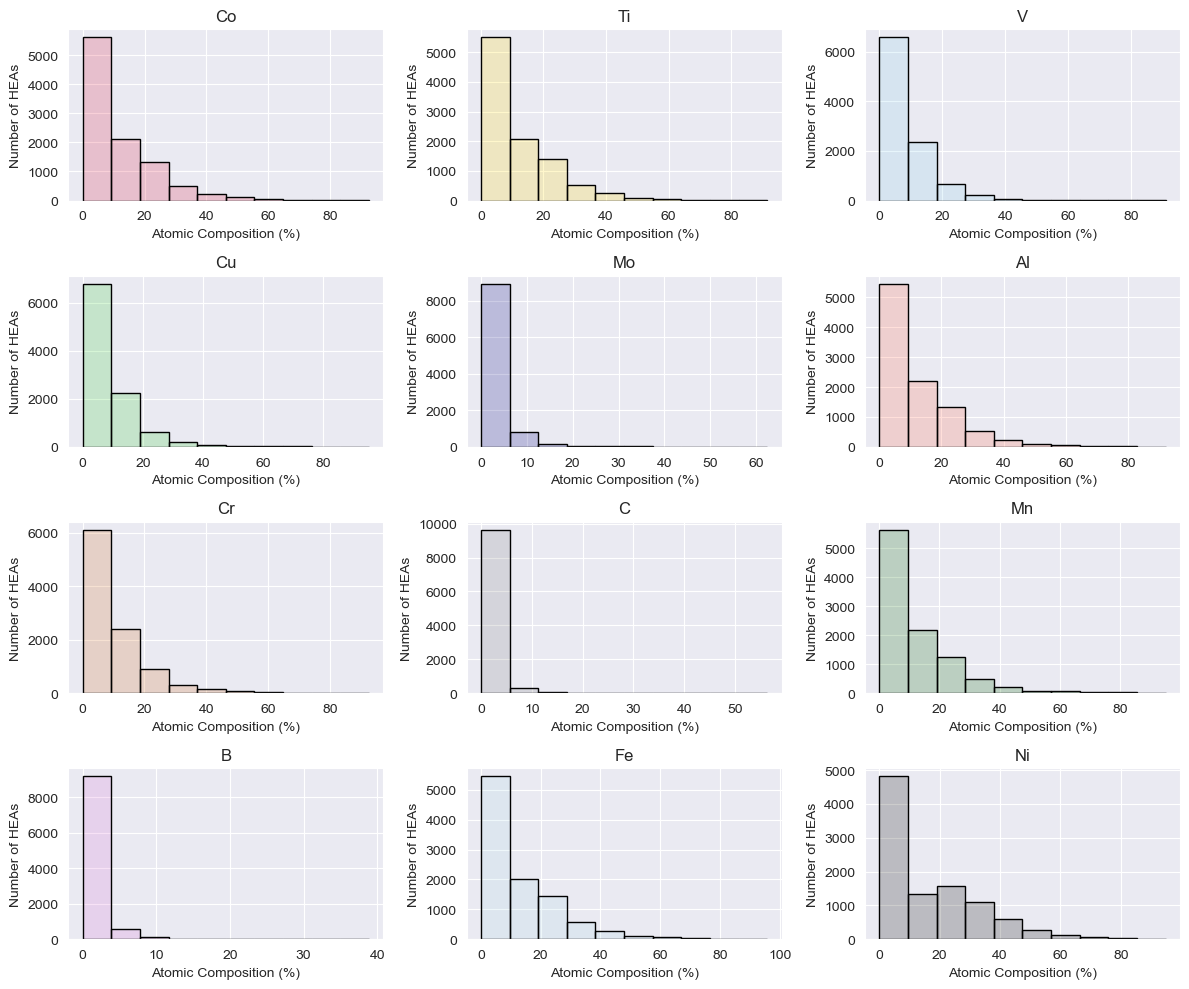

In [23]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(4, 3, 1)
sns.histplot(x = "Co", data = synthetic_df, color = "crimson", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Co")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 2)
sns.histplot(x = "Ti", data = synthetic_df, color = "gold", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Ti")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 3)
sns.histplot(x = "V", data = synthetic_df, color = "skyblue", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("V")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 4)
sns.histplot(x = "Cu", data = synthetic_df, color = "limegreen",alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Cu")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 5)
sns.histplot(x = "Mo", data = synthetic_df, color = "navy", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Mo")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 6)
sns.histplot(x = "Al", data = synthetic_df, color = "tomato", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Al")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 7)
sns.histplot(x = "Cr", data = synthetic_df, color = "chocolate", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Cr")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 8)
sns.histplot(x = "C", data = synthetic_df, color = "grey", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("C")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 9)
sns.histplot(x = "Mn", data = synthetic_df, color = "darkgreen", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Mn")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 10)
sns.histplot(x = "B", data = synthetic_df, color = "orchid", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("B")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 11)
sns.histplot(x = "Fe", data = synthetic_df, color = "lightblue", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Fe")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 12)
sns.histplot(x = "Ni", data = synthetic_df, color = "black", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Ni")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.tight_layout()
plt.show()

##### **6. Visualization of Processing Temperature on Synthetic Data**

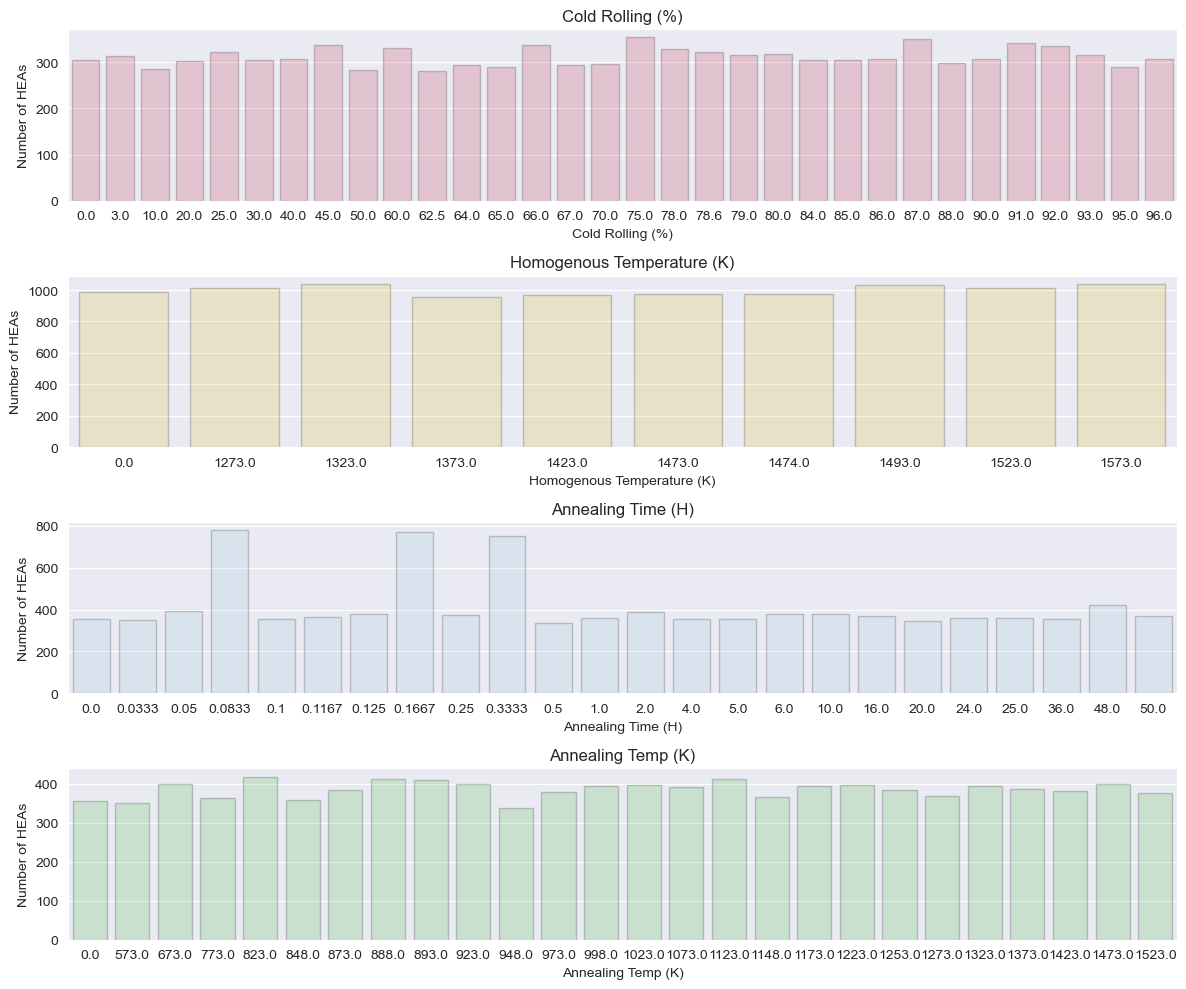

In [24]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(4, 1, 1)
sns.countplot(x = "cold_rolling", data = synthetic_df, color = "crimson", alpha = 0.2, edgecolor = "black")
plt.title("Cold Rolling (%)")
plt.xlabel("Cold Rolling (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 2)
sns.countplot(x = "homo_temp", data = synthetic_df, color = "gold", alpha = 0.2, edgecolor = "black")
plt.title("Homogenous Temperature (K)")
plt.xlabel("Homogenous Temperature (K)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 3)
sns.countplot(x = "anneal_time", data = synthetic_df, color = "skyblue", alpha = 0.2, edgecolor = "black")
plt.title("Annealing Time (H)")
plt.xlabel("Annealing Time (H)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 4)
sns.countplot(x = "anneal_temp", data = synthetic_df, color = "limegreen",alpha = 0.2, edgecolor = "black")
plt.title("Annealing Temp (K)")
plt.xlabel("Annealing Temp (K)")
plt.ylabel("Number of HEAs")
plt.tight_layout()
plt.show()

##### **7. Visualization of Inverse Predicted Mechanical Properties on Synthetic Data**

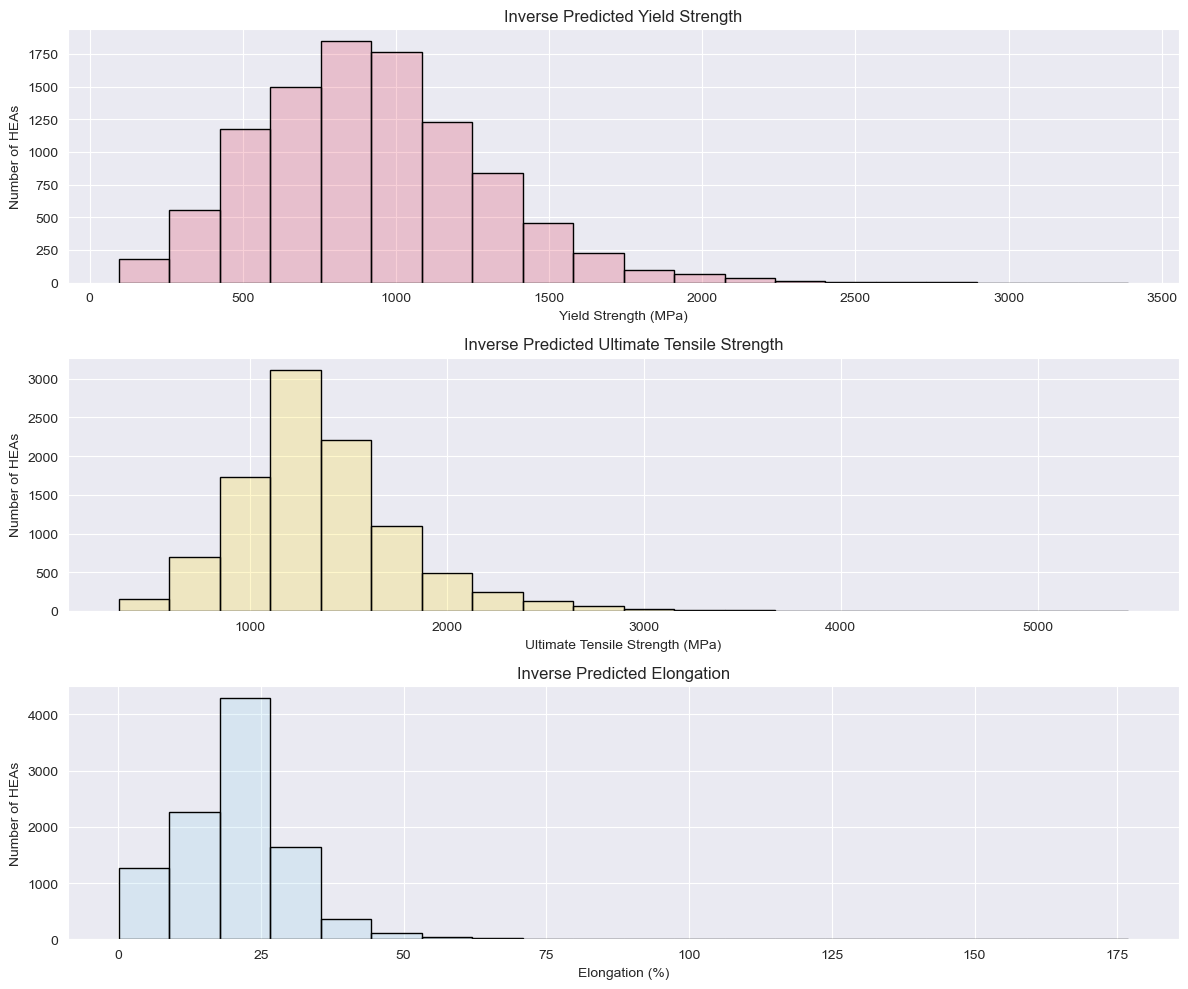

In [25]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(3, 1, 1)
sns.histplot(x = "pred_YS", data = synthetic_df, color = "crimson", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Yield Strength")
plt.xlabel("Yield Strength (MPa)")
plt.ylabel("Number of HEAs")

plt.subplot(3, 1, 2)
sns.histplot(x = "pred_UTS", data = synthetic_df, color = "gold", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Ultimate Tensile Strength")
plt.xlabel("Ultimate Tensile Strength (MPa)")
plt.ylabel("Number of HEAs")

plt.subplot(3, 1, 3)
sns.histplot(x = "pred_EL", data = synthetic_df, color = "skyblue", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Elongation")
plt.xlabel("Elongation (%)")
plt.ylabel("Number of HEAs")

plt.tight_layout()
plt.show()

##### **8. Filtering**

In [26]:
# filter those rows with more than 10% composition of carbon and boron
synthetic_df = synthetic_df[synthetic_df['C'] < 10]
synthetic_df = synthetic_df[synthetic_df['B'] < 10]

In [27]:
# filter those rows with less than 10% elongation
synthetic_df = synthetic_df[synthetic_df['pred_EL'] >= 10]

In [28]:
# check for any duplicated rows 
synthetic_df.duplicated().value_counts()

False    8508
Name: count, dtype: int64

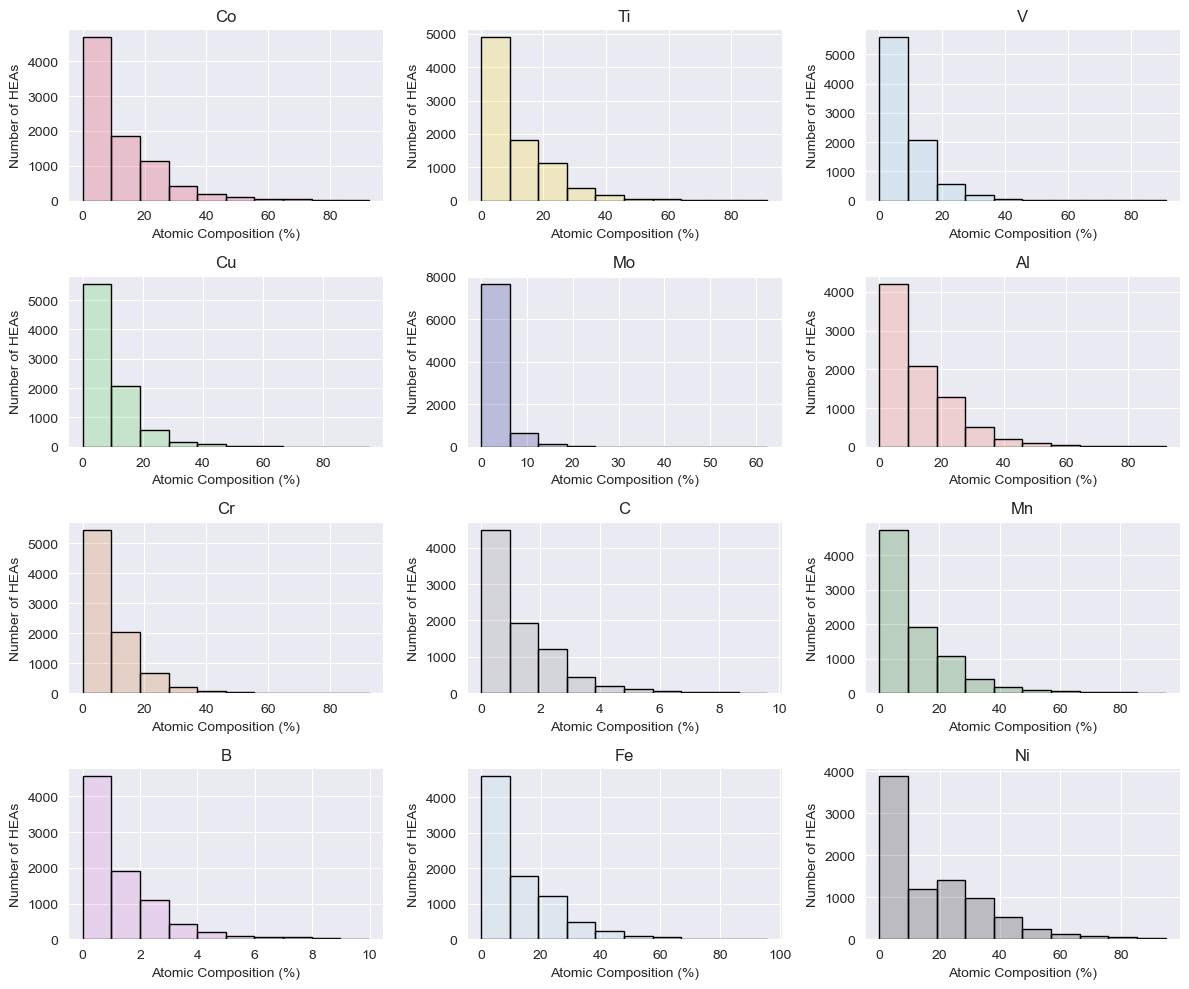

In [30]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(4, 3, 1)
sns.histplot(x = "Co", data = synthetic_df, color = "crimson", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Co")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 2)
sns.histplot(x = "Ti", data = synthetic_df, color = "gold", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Ti")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 3)
sns.histplot(x = "V", data = synthetic_df, color = "skyblue", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("V")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 4)
sns.histplot(x = "Cu", data = synthetic_df, color = "limegreen",alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Cu")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 5)
sns.histplot(x = "Mo", data = synthetic_df, color = "navy", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Mo")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 6)
sns.histplot(x = "Al", data = synthetic_df, color = "tomato", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Al")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 7)
sns.histplot(x = "Cr", data = synthetic_df, color = "chocolate", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Cr")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 8)
sns.histplot(x = "C", data = synthetic_df, color = "grey", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("C")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 9)
sns.histplot(x = "Mn", data = synthetic_df, color = "darkgreen", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Mn")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 10)
sns.histplot(x = "B", data = synthetic_df, color = "orchid", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("B")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 11)
sns.histplot(x = "Fe", data = synthetic_df, color = "lightblue", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Fe")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 3, 12)
sns.histplot(x = "Ni", data = synthetic_df, color = "black", alpha = 0.2, bins = 10, edgecolor = "black")
plt.title("Ni")
plt.xlabel("Atomic Composition (%)")
plt.ylabel("Number of HEAs")

plt.tight_layout()
plt.show()

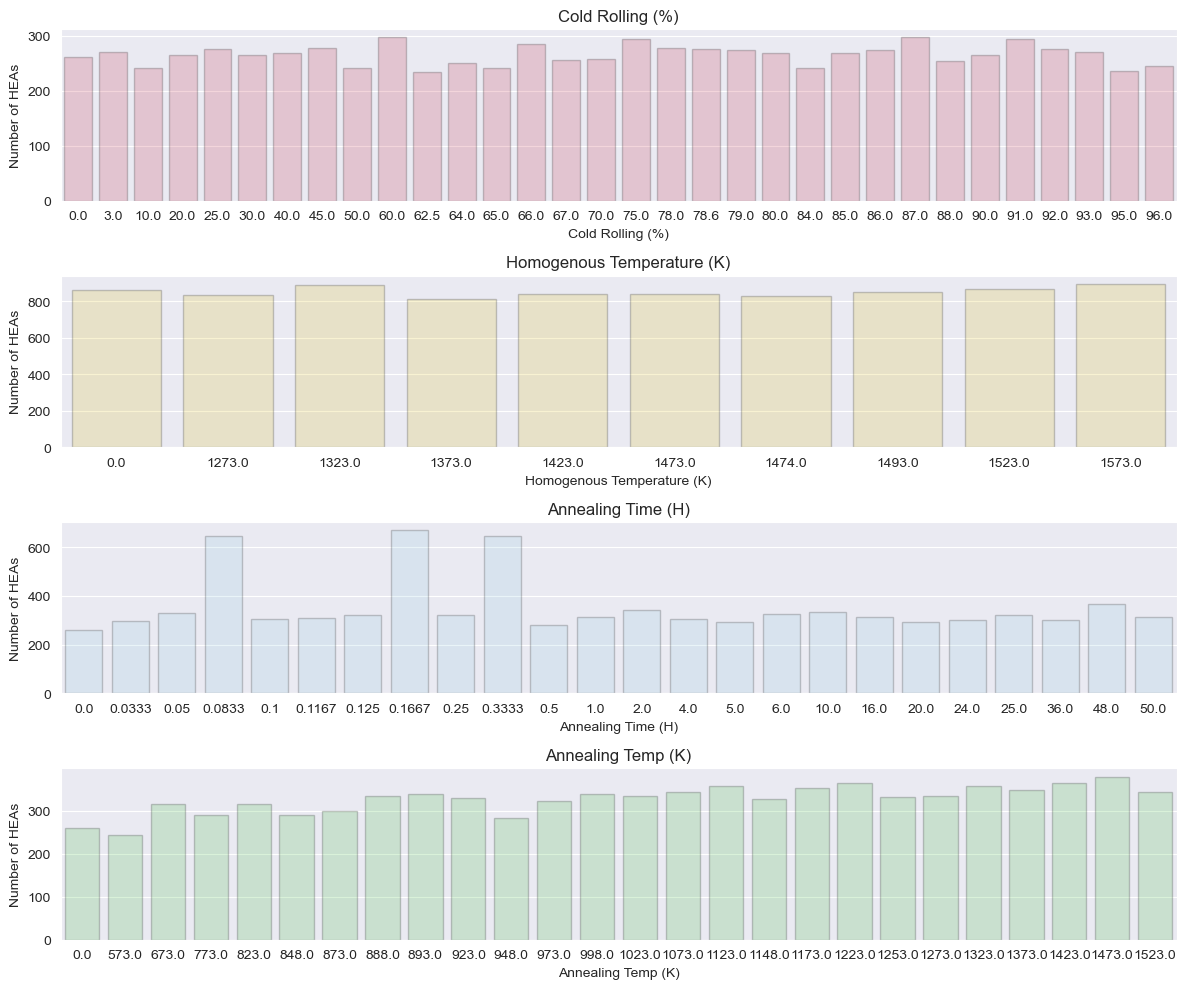

In [31]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(4, 1, 1)
sns.countplot(x = "cold_rolling", data = synthetic_df, color = "crimson", alpha = 0.2, edgecolor = "black")
plt.title("Cold Rolling (%)")
plt.xlabel("Cold Rolling (%)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 2)
sns.countplot(x = "homo_temp", data = synthetic_df, color = "gold", alpha = 0.2, edgecolor = "black")
plt.title("Homogenous Temperature (K)")
plt.xlabel("Homogenous Temperature (K)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 3)
sns.countplot(x = "anneal_time", data = synthetic_df, color = "skyblue", alpha = 0.2, edgecolor = "black")
plt.title("Annealing Time (H)")
plt.xlabel("Annealing Time (H)")
plt.ylabel("Number of HEAs")

plt.subplot(4, 1, 4)
sns.countplot(x = "anneal_temp", data = synthetic_df, color = "limegreen",alpha = 0.2, edgecolor = "black")
plt.title("Annealing Temp (K)")
plt.xlabel("Annealing Temp (K)")
plt.ylabel("Number of HEAs")
plt.tight_layout()
plt.show()

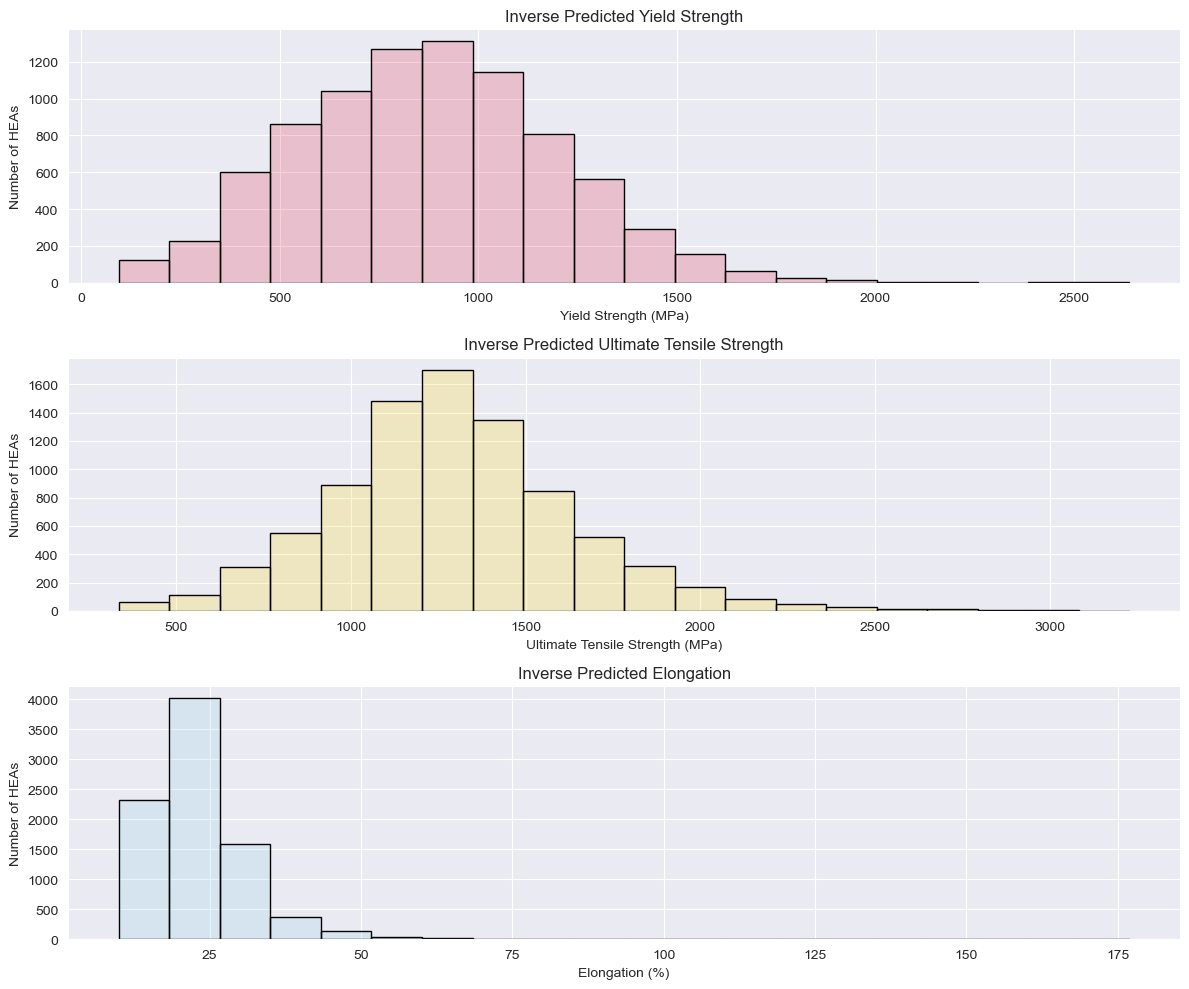

In [32]:
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
plt.subplot(3, 1, 1)
sns.histplot(x = "pred_YS", data = synthetic_df, color = "crimson", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Yield Strength")
plt.xlabel("Yield Strength (MPa)")
plt.ylabel("Number of HEAs")

plt.subplot(3, 1, 2)
sns.histplot(x = "pred_UTS", data = synthetic_df, color = "gold", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Ultimate Tensile Strength")
plt.xlabel("Ultimate Tensile Strength (MPa)")
plt.ylabel("Number of HEAs")

plt.subplot(3, 1, 3)
sns.histplot(x = "pred_EL", data = synthetic_df, color = "skyblue", bins = 20, alpha = 0.2, edgecolor = "black")
plt.title("Inverse Predicted Elongation")
plt.xlabel("Elongation (%)")
plt.ylabel("Number of HEAs")

plt.tight_layout()
plt.show()

##### **9. Find HEA 1 with highest UTS**

In [33]:
# find the maximum predicted UTS in the synthetic data
max_UTS = max(synthetic_df['pred_UTS'])
max_UTS

3227.972

In [34]:
# extract rows with UTS greater than 2000
uts_gt_2000 = synthetic_df[synthetic_df['pred_UTS'] >= max_UTS - 500]
# sort the dataframe by predicted UTS from highest to lowest order
uts_gt_2000 = uts_gt_2000.sort_values(by = "pred_UTS", ascending = False)
# display only the UTS in descending order
uts_gt_2000['pred_UTS']

4404    3227.9720
5804    3086.8413
8566    3050.4373
3948    3046.9866
9530    3019.7390
4238    2952.8420
1828    2894.3680
9325    2857.5340
6005    2811.3975
1441    2810.5350
6291    2805.1333
2743    2787.0378
7098    2774.4740
7982    2769.2756
Name: pred_UTS, dtype: float64

In [50]:
# find the highest uts
hea1 = max(uts_gt_2000['pred_UTS'])

# extract rows with highest uts
hea1 = uts_gt_2000[uts_gt_2000['pred_UTS'] == hea1]

pd.set_option('display.float_format', '{:.6f}'.format)

# display the row with highest uts
hea1.T

,4404
Co,0.000000
Ti,0.000000
V,0.000000
Cu,0.000000
Mo,0.000000
Al,89.431700
Cr,0.000000
C,6.571500
Mn,0.000000
B,0.000000


In [36]:
chemical_comp_hea1 = hea1[['Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni']]
elementName = ['Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni']

chemical_comp_hea1_str = ""
for element in elementName:
    if chemical_comp_hea1.iloc[0][element] != 0.0:
        chemical_comp_hea1_str += "{}: {}".format(element, chemical_comp_hea1.iloc[0][element], 3) + "%  "
chemical_comp_hea1_str

'Al: 89.4317%  C: 6.5715%  Ni: 3.9968%  '

##### **10. Find HEA 2 with second highest UTS**

In [49]:
# find the second highest UTS
hea2 = uts_gt_2000['pred_UTS'].iloc[1]

# extract rows with second highest UTS
hea2 = uts_gt_2000[uts_gt_2000['pred_UTS'] == hea2]

pd.set_option('display.float_format', '{:.6f}'.format)

# display the row with second highest UTS
hea2.T

,5804
Co,0.000000
Ti,0.000000
V,0.000000
Cu,18.865300
Mo,1.385000
Al,69.933400
Cr,0.000000
C,8.110000
Mn,0.000000
B,1.706300


In [38]:
chemical_comp_hea2 = hea2[['Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni']]
elementName = ['Co', 'Ti', 'V', 'Cu', 'Mo', 'Al', 'Cr', 'C', 'Mn', 'B', 'Fe', 'Ni']

chemical_comp_hea2_str = ""
for element in elementName:
    if chemical_comp_hea2.iloc[0][element] != 0.0:
        chemical_comp_hea2_str += "{}: {}".format(element, chemical_comp_hea2.iloc[0][element], 3) + "%  "
chemical_comp_hea2_str

'Cu: 18.8653%  Mo: 1.385%  Al: 69.9334%  C: 8.11%  B: 1.7063%  '

##### **11. Visualization of Ultimate Tensile Strength vs. Density Comparison**

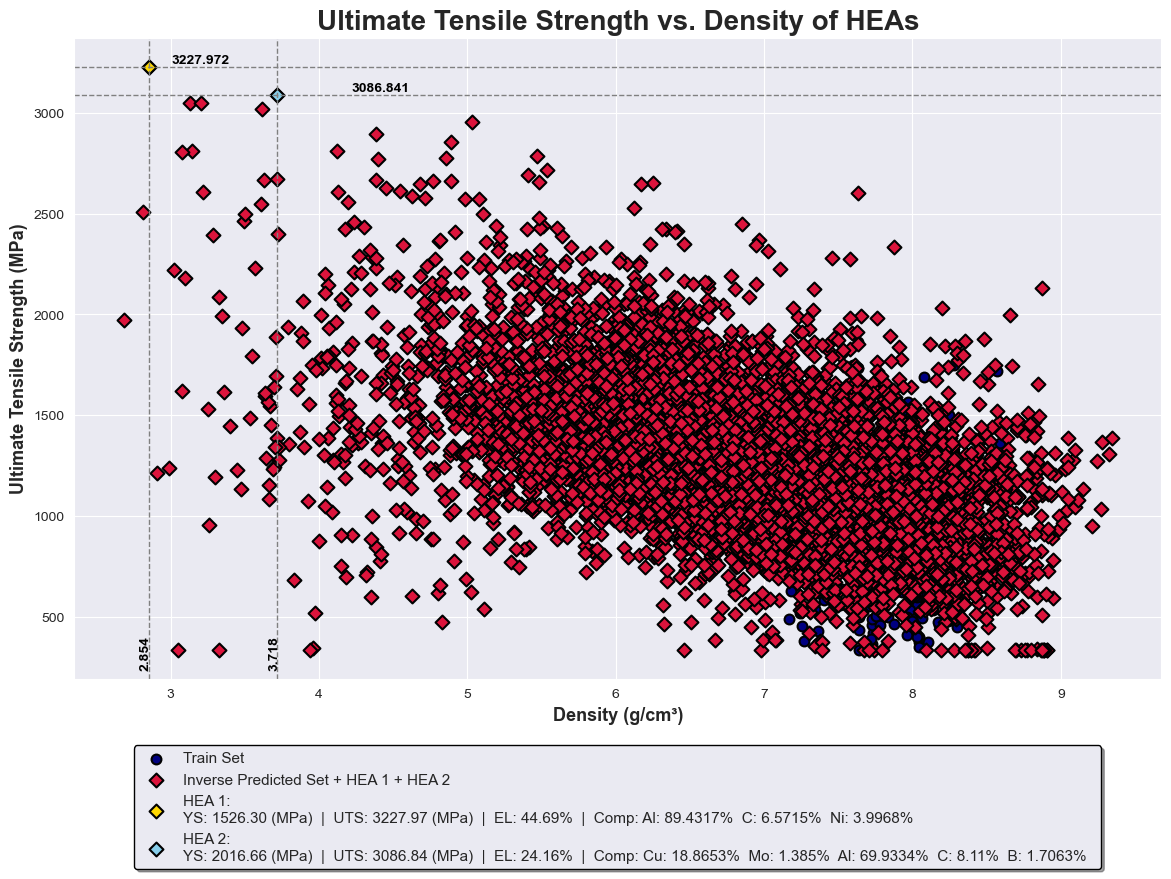

In [48]:
plt.figure(figsize = (12, 9))
sns.set_style("darkgrid")
# plot for training set
sns.scatterplot(x = "Density", 
                y = "ultimate_tensile_strength", 
                data = cleaned_new_trained_ed, 
                edgecolor = "black",
                linewidth = 1.5, 
                marker = "o",
                color = "navy",
                s = 50, 
                label = "Train Set")

# plot for inverse predicted data
sns.scatterplot(x = "Density", 
                y = "pred_UTS", 
                data = synthetic_df, 
                edgecolor = "black",
                linewidth = 1.5,
                marker = 'D', 
                color = "crimson",
                s = 50, 
                label = "Inverse Predicted Set + HEA 1 + HEA 2")

# plot for hea 1
sns.scatterplot(x = "Density", 
                y = "pred_UTS", 
                data = hea1, 
                edgecolor = "black",
                linewidth = 1.5, 
                marker = "D", 
                color = "gold",
                s = 50, 
                label = "HEA 1: \nYS: {:.2f} (MPa)  |  UTS: {:.2f} (MPa)  |  EL: {:.2f}%  |  Comp: {}".format(hea1.iloc[0]['pred_YS'], hea1.iloc[0]['pred_UTS'], hea1.iloc[0]['pred_EL'], chemical_comp_hea1_str))

# plot for hea 2
sns.scatterplot(x = "Density", 
                y = "pred_UTS", 
                data = hea2, 
                edgecolor = "black",
                linewidth = 1.5, 
                marker = "D", 
                color = "skyblue",
                s = 50, 
                label = "HEA 2: \nYS: {:.2f} (MPa)  |  UTS: {:.2f} (MPa)  |  EL: {:.2f}%  |  Comp: {}".format(hea2.iloc[0]['pred_YS'], hea2.iloc[0]['pred_UTS'], hea2.iloc[0]['pred_EL'], chemical_comp_hea2_str))

# allocate and annotate the HEA1
plt.axhline(y = hea1.iloc[0]['pred_UTS'], color = 'grey', linestyle = '--', linewidth = 1)
plt.axvline(x = hea1.iloc[0]['Density'], color = 'grey', linestyle = '--', linewidth = 1)
plt.text(hea1.iloc[0]['Density'] +0.15, hea1.iloc[0]['pred_UTS'] + 20, round(hea1.iloc[0]['pred_UTS'], 3), fontsize = 10, color='black', fontweight = "bold")
plt.text(hea1.iloc[0]['Density'] - 0.06, 250, round(hea1.iloc[0]['Density'], 3), fontsize = 10, color='black', fontweight = "bold", rotation = 90)

# allocate and annotate the HEA2
plt.axhline(y = hea2.iloc[0]['pred_UTS'], color = 'grey', linestyle = '--', linewidth = 1)
plt.axvline(x = hea2.iloc[0]['Density'], color = 'grey', linestyle = '--', linewidth = 1)
plt.text(hea2.iloc[0]['Density'] +0.5, hea2.iloc[0]['pred_UTS'] + 20, round(hea2.iloc[0]['pred_UTS'], 3), fontsize = 10, color='black', fontweight = "bold")
plt.text(hea2.iloc[0]['Density'] - 0.06, 250, round(hea2.iloc[0]['Density'], 3), fontsize = 10, color='black', fontweight = "bold", rotation = 90)

# axis title and labels
plt.title("Ultimate Tensile Strength vs. Density of HEAs", fontsize = 20, fontweight = "bold")
plt.xlabel("Density (g/cm³)", fontsize = 13, fontweight = 'bold')
plt.ylabel("Ultimate Tensile Strength (MPa)", fontsize = 13, fontweight = 'bold')
plt.legend(edgecolor = "black", shadow = True, fontsize = 11, loc = 'center', bbox_to_anchor = (0.5, -0.2))
plt.tight_layout()
plt.show()